# Contents:

In this notebook, we will

1. use data assimilation to calculate D&B parameter posteriors
2. forward run D&B with posteriors
3. compare the forward output data using priors against posteriors
4. compare the forward output data with observations.

# Setup environment

In [1]:
!pip install git+https://github.com/soonyenju/tccas.git -U --quiet

  Preparing metadata (setup.py) ... done


In [2]:
from tccas.env_setup import *

Do you want to prepare TCCAS? (y/n): y
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running TCCAS model setup...
Copying /content/drive/My Drive/tccas/bak/tccas_r10043.tgz -> /content/tccas_r10043.tgz
Extracting /content/tccas_r10043.tgz
Linking /content/tccas_r10043/config/mk.compile-gfortran -> /content/tccas_r10043/mk.compile
✅ TCCAS prepared successfully!
No module named 'netCDF4', so `netCDF4` is installing it for you...


# Run data assimilation

This subsection includes five lines:

0) remove file x.b with control vector from previous assimilation experiments
1) assimilate the D&B parameters
2) copy the posterior parameter file to a file x.b, such that its values are read in by the model to over-write the prior parameter values
3) forward run the D&B model with posteriors
2) copy the diagnostic outputs into the *resources* folder we created above.

---

Note:

The `clean` target removes object files produced from the previous run.\
Final parameter set that it identified as the cost function minimum in binary (`xopt.b`).\
Run `rm -rf tccas_r10043` if you want to delete the training folder later on (Warning: be careful).

In [3]:
set_iteration_number(root_proj, niter = 10)

The iteration number 'itmax' has been changed from 10 to 10


## ES-LM1

In [4]:
%%bash

rm -f x.b
make -s scratch xassi DOMAIN=ES-LM1

cp xopt.b x.b
make -s clean xmodel DOMAIN=ES-LM1

cp -a diagout/. resources/ES-LM1_posterior

INFO::  prepending +++/content/tccas_r10043/util/pylcc+++ to module search path
2025-09-22 06:06:32,993 INFO::<module>:: model_setup.py::PROGRAM START::2025-09-22T06:06:32.992949
2025-09-22 06:06:32,993 INFO::<module>:: command-line: util/model_setup.py dimensions_setup --outname src/dimensions.f90 --calendar=gregorian --dates 20150101 20211231 input/staticforcing.nc input/dynforcing.nc
2025-09-22 06:06:32,996 INFO::main:: START requested subcommand +++dimensions_setup+++...
2025-09-22 06:06:32,996 INFO::subcmd_dimensions_setup:: determine temporal/spatial settings from forcing file ***input/staticforcing.nc***
2025-09-22 06:06:33,008 INFO::subcmd_dimensions_setup:: static forcing file contains grid-cells with 2 different PFTs (---[3 9]---)
2025-09-22 06:06:33,009 INFO::subcmd_dimensions_setup:: checking consistency of selected period with dynamic forcing provided (input/dynforcing.nc)
2025-09-22 06:06:33,009 INFO::subcmd_dimensions_setup:: simulation period forseen 20150101T01--202201

adStack.c: In function ‘adStack_showPeakSize’:
adStack.c:1065:46: warning: format ‘%llu’ expects argument of type ‘long long unsigned int’, but argument 3 has type ‘long unsigned int’ [-Wformat=]
 1065 |   printf("Peak stack size (%1li blocks): %1llu bytes\n",
      |                                          ~~~~^
      |                                              |
      |                                              long long unsigned int
      |                                          %1lu
 1066 |          maxBlocks, maxBlocks*((long int)BLOCK_SIZE)) ;
      |                     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      |                              |
      |                              long unsigned int
ar: creating ../libadstack-gfortran.a
ar: creating ../libmini-gfortran.a


This is what some output information looks like.\
First we see, how the assimilation procedure iteratively decreases the value of the cost function (f= ...) over the 10 iterations that we allow.
Next we see prior and posterior parameter values and their differences relative to the prior and relative to the prior uncertainty.

## FI-Sod

In [5]:
%%bash
rm -f x.b
make -s scratch xassi DOMAIN=FI-Sod

cp xopt.b x.b
make -s clean xmodel DOMAIN=FI-Sod

cp -a diagout/. resources/FI-Sod_posterior

INFO::  prepending +++/content/tccas_r10043/util/pylcc+++ to module search path
2025-09-22 06:08:11,048 INFO::<module>:: model_setup.py::PROGRAM START::2025-09-22T06:08:11.048031
2025-09-22 06:08:11,048 INFO::<module>:: command-line: util/model_setup.py dimensions_setup --outname src/dimensions.f90 --calendar=gregorian --dates 20150101 20211231 input/staticforcing.nc input/dynforcing.nc
2025-09-22 06:08:11,051 INFO::main:: START requested subcommand +++dimensions_setup+++...
2025-09-22 06:08:11,051 INFO::subcmd_dimensions_setup:: determine temporal/spatial settings from forcing file ***input/staticforcing.nc***
2025-09-22 06:08:11,056 INFO::subcmd_dimensions_setup:: static forcing file contains grid-cells with 2 different PFTs (---[5 7]---)
2025-09-22 06:08:11,056 INFO::subcmd_dimensions_setup:: checking consistency of selected period with dynamic forcing provided (input/dynforcing.nc)
2025-09-22 06:08:11,057 INFO::subcmd_dimensions_setup:: simulation period forseen 20150101T01--202201

adStack.c: In function ‘adStack_showPeakSize’:
adStack.c:1065:46: warning: format ‘%llu’ expects argument of type ‘long long unsigned int’, but argument 3 has type ‘long unsigned int’ [-Wformat=]
 1065 |   printf("Peak stack size (%1li blocks): %1llu bytes\n",
      |                                          ~~~~^
      |                                              |
      |                                              long long unsigned int
      |                                          %1lu
 1066 |          maxBlocks, maxBlocks*((long int)BLOCK_SIZE)) ;
      |                     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      |                              |
      |                              long unsigned int
ar: creating ../libadstack-gfortran.a
ar: creating ../libmini-gfortran.a


# Let's fetch our backup results

In [6]:
bak_dir = Path('/content/drive/My Drive/tccas')

src = bak_dir / "bak" / "resources"
dst = root_proj / "resources"

for file in src.rglob("*"):  # rglob("*") = recursive
    if file.is_file():
        relative_path = file.relative_to(src)
        target = dst / relative_path
        target.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(file, target)

print(f"✅ Copied all files from {src} to {dst}")

src = bak_dir / "bak" / "analysis"
dst = root_proj / "analysis"

for file in src.rglob("*"):  # rglob("*") = recursive
    if file.is_file():
        relative_path = file.relative_to(src)
        target = dst / relative_path
        target.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(file, target)

print(f"✅ Copied all files from {src} to {dst}")

✅ Copied all files from /content/drive/My Drive/tccas/bak/resources to /content/tccas_r10043/resources
✅ Copied all files from /content/drive/My Drive/tccas/bak/analysis to /content/tccas_r10043/analysis


# Comparisons between using prior and posterior parameters

## ES-LM1

In [7]:
site = 'ES-LM1'
dfa1, dfa2 = load_DB_outputs(site, root_proj, prior = True, freq = 'daily').values()  # 'C3Gr' C3 grass
dfb1, dfb2 = load_DB_outputs(site, root_proj, prior = False, freq = 'daily').values() # 'TmEv' Temperate broadleaf evergreen tree

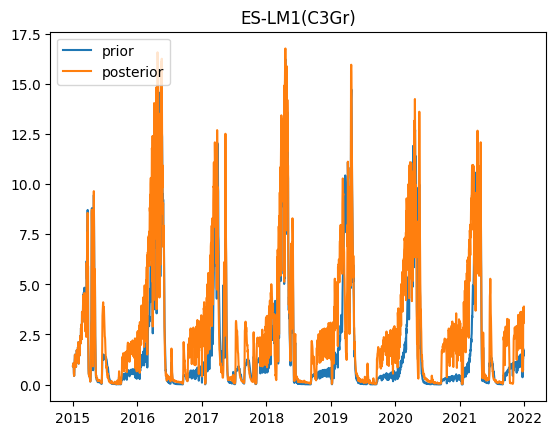

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(dfa1['gpp'], label = 'prior')
ax.plot(dfb1['gpp'], label = 'posterior')
ax.legend(loc = 2)
ax.set_title(site + '(C3Gr)')

fig.savefig(root_proj.joinpath('analysis/gpp-priorVSposterior_ES-LM1_C3Gr.png'))

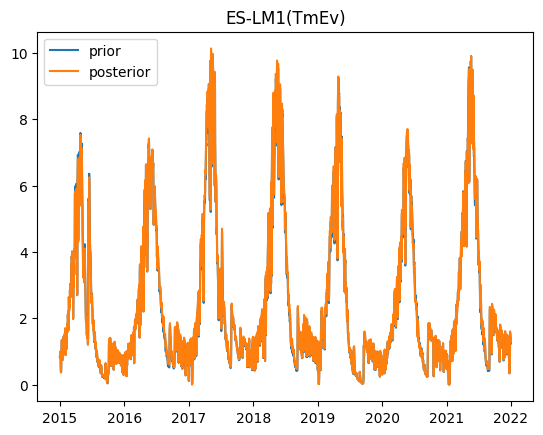

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(dfa2['gpp'], label = 'prior')
ax.plot(dfb2['gpp'], label = 'posterior')
ax.legend(loc = 2)
ax.set_title(site + '(TmEv)')

fig.savefig(root_proj.joinpath('analysis/gpp-priorVSposterior_ES-LM1_TmEv.png'))

## FI-Sod

In [10]:
site = 'FI-Sod'
dfa1, dfa2 = load_DB_outputs(site, root_proj, prior = True, freq = 'daily').values()  # 'EvCn' Evergreen coniferous tree
dfb1, dfb2 = load_DB_outputs(site, root_proj, prior = False, freq = 'daily').values() # 'EShr' Evergreen shrub

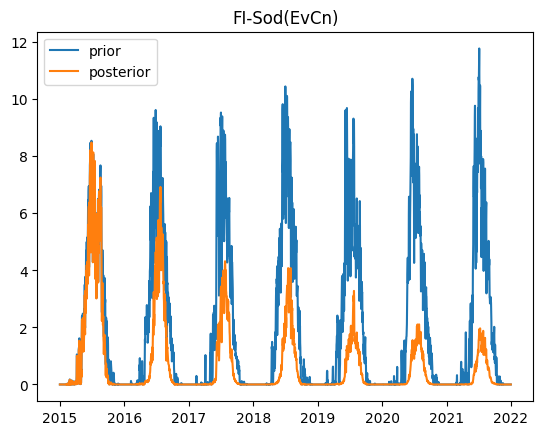

In [11]:
fig, ax = plt.subplots(1, 1)
ax.plot(dfa1['gpp'], label = 'prior')
ax.plot(dfb1['gpp'], label = 'posterior')
ax.legend(loc = 2)
ax.set_title(site + '(EvCn)')

fig.savefig(root_proj.joinpath('analysis/gpp-priorVSposterior_FI-Sod_EvCn.png'))

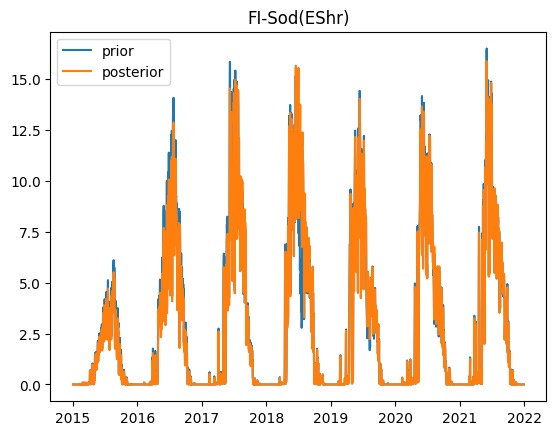

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(dfa2['gpp'], label = 'prior')
ax.plot(dfb2['gpp'], label = 'posterior')
ax.legend(loc = 2)
ax.set_title(site + '(EShr)')

fig.savefig(root_proj.joinpath('analysis/gpp-priorVSposterior_FI-Sod_EShr.png'))

# Compare with observations

In [14]:
dd_obs = load_observations('FI-Sod', root_proj, freq = 'daily')
if type(dd_obs) == pd.core.frame.DataFrame: print(dfa1.columns.intersection(dd_obs.columns))
# 'vod', 'fapar', 'sif743'
# print(dd_obs.head(n = 10))

Index(['gpp', 'nee', 'vod', 'slope', 'fapar', 'sif743'], dtype='object')


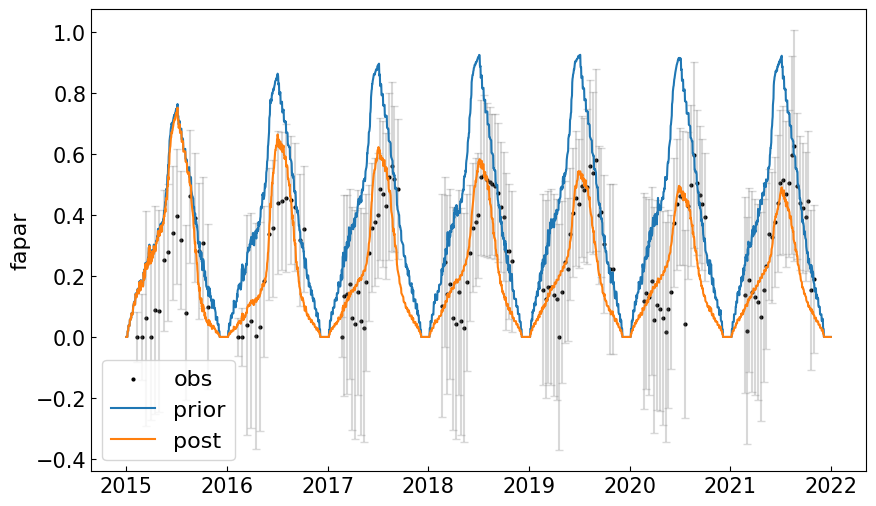

In [15]:
var_name = 'fapar'
fig, ax = setup_canvas(1, 1)

dfa_agg = aggPFT(dfa1, dfa2, var_name)
dfb_agg = aggPFT(dfb1, dfb2, var_name)

ax.scatter(dd_obs[var_name].index, dd_obs[var_name], label = 'obs', color = 'k')
ax.errorbar(dd_obs.index, dd_obs[var_name], yerr=dd_obs[var_name + '_unc'], capsize=3, ls = 'none', ecolor = 'grey', alpha = 0.3)
ax.plot(dfa_agg.index, dfa_agg, label = 'prior', color = colors[0])
ax.plot(dfb_agg.index, dfb_agg, label = 'post', color = colors[1])
ax.set_ylabel(var_name)
ax.legend()

fig = plt.gcf()
fig.savefig(root_proj.joinpath(f'analysis/{var_name}-modelVSobs.png'))

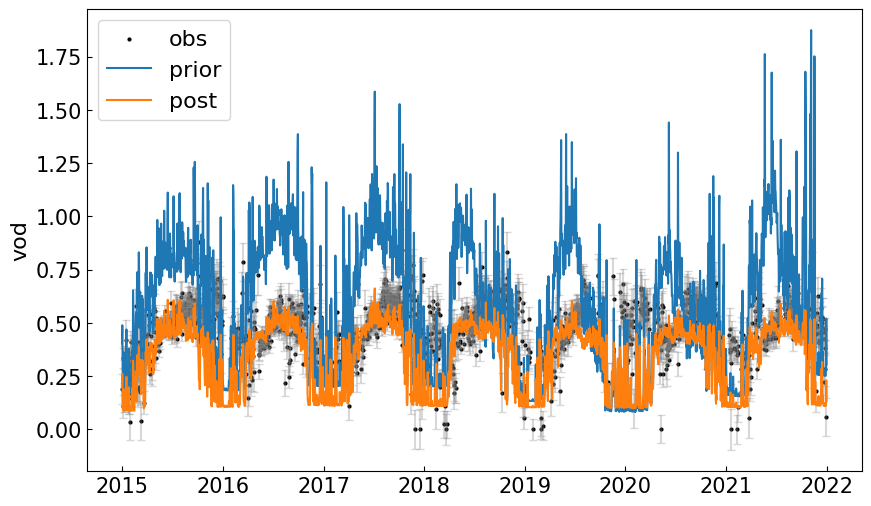

In [16]:
var_name = 'vod'
fig, ax = setup_canvas(1, 1)

dfa_agg = aggPFT(dfa1, dfa2, var_name)
dfb_agg = aggPFT(dfb1, dfb2, var_name)

ax.scatter(dd_obs[var_name].index, dd_obs[var_name], label = 'obs', color = 'k')
ax.errorbar(dd_obs.index, dd_obs[var_name], yerr=dd_obs[var_name + '_unc'], capsize=3, ls = 'none', ecolor = 'grey', alpha = 0.3)
ax.plot(dfa_agg.index, dfa_agg, label = 'prior', color = colors[0])
ax.plot(dfb_agg.index, dfb_agg, label = 'post', color = colors[1])
ax.set_ylabel(var_name)
ax.legend()

fig = plt.gcf()
fig.savefig(root_proj.joinpath(f'analysis/{var_name}-modelVSobs.png'))

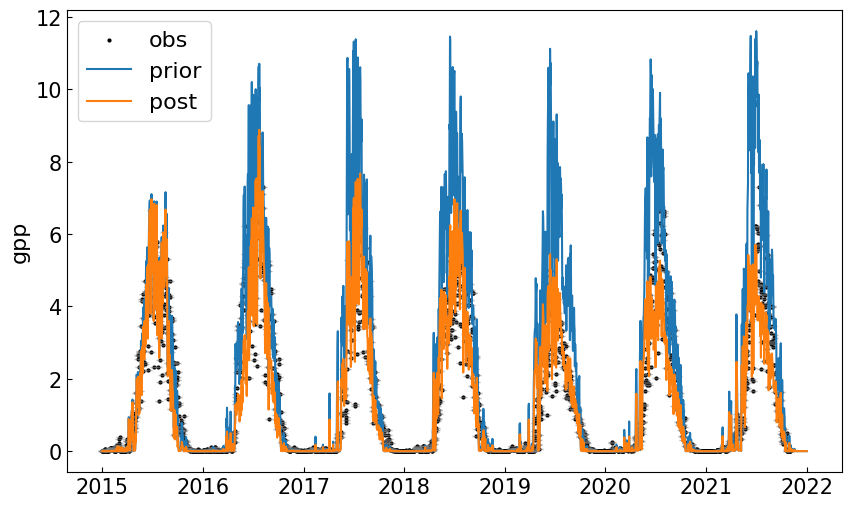

In [17]:
var_name = 'gpp'
fig, ax = setup_canvas(1, 1)

dfa_agg = aggPFT(dfa1, dfa2, var_name)
dfb_agg = aggPFT(dfb1, dfb2, var_name)

ax.scatter(dd_obs[var_name].index, dd_obs[var_name], label = 'obs', color = 'k')
ax.errorbar(dd_obs.index, dd_obs[var_name], yerr=dd_obs[var_name + '_unc'], capsize=3, ls = 'none', ecolor = 'grey', alpha = 0.3)
ax.plot(dfa_agg.index, dfa_agg, label = 'prior', color = colors[0])
ax.plot(dfb_agg.index, dfb_agg, label = 'post', color = colors[1])
ax.set_ylabel(var_name)
ax.legend()

fig = plt.gcf()
fig.savefig(root_proj.joinpath(f'analysis/{var_name}-modelVSobs.png'))

# Let's backup our results

In [18]:
src = root_proj / "resources"
dst = bak_dir / "bak" / "resources"

for file in src.rglob("*"):  # rglob("*") = recursive
    if file.is_file():
        relative_path = file.relative_to(src)
        target = dst / relative_path
        target.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(file, target)

print(f"✅ Copied all files from {src} to {dst}")

src = root_proj / "analysis"
dst = bak_dir / "bak" / "analysis"

for file in src.rglob("*"):  # rglob("*") = recursive
    if file.is_file():
        relative_path = file.relative_to(src)
        target = dst / relative_path
        target.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(file, target)

print(f"✅ Copied all files from {src} to {dst}")

✅ Copied all files from /content/tccas_r10043/resources to /content/drive/My Drive/tccas/bak/resources
✅ Copied all files from /content/tccas_r10043/analysis to /content/drive/My Drive/tccas/bak/analysis


# Practices and questions <a class="anchor" id="section4"></a>

Note: the observations also come with errors!


Does data assimilation give exactly what we want? Is the posterior close to observation?